## Building an optimized CNN Model for Morgan fingerprints

This Notebook will uses Keras Tuner to find the best hyperparameters for a CNN model which will label molecules according to their Morgan fingerprints

#### In case the requirements.txt file won't work

In [3]:
#pip install keras_tuner

                                              0.0/176.1 kB ? eta -:--:--
     --                                       10.2/176.1 kB ? eta -:--:--
     -------------------------------------  174.1/176.1 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 176.1/176.1 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Imports

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import unique
from numpy import argmax
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### Loading data

In [5]:
all_drugs = pd.read_pickle(os.path.join('res', 'pickles', 'drug_fp.pkl'))

In [6]:
drugs = all_drugs
drugs.head()

,CID,Molecule,drug_class,drug_class_code,FeatInvariants,ConnInvariants,Morgan2FP,MACCSKeys,AtomPairFP,TopTorFP,AvalonFP,PubchemFP,CactvsFP
0,24769,<rdkit.Chem.rdchem.Mol object at 0x000001E46DA...,hematologic,7,"[0, 18, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 8...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
1,134694070,<rdkit.Chem.rdchem.Mol object at 0x000001E46DA...,cardio,3,"[0, 0, 2, 0, 17, 17, 4, 4, 4, 6, 4, 4, 6, 4, 4...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
2,5121,<rdkit.Chem.rdchem.Mol object at 0x000001E46DA...,antiinfective,0,"[0, 0, 2, 0, 2, 0, 0, 16, 4, 4, 4, 4, 4, 4, 8]","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
3,4660557,<rdkit.Chem.rdchem.Mol object at 0x000001E46DA...,cns,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 4, 4, 4, 4,...","[2968968094, 2976033787, 2968968094, 297603378...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
4,122175,<rdkit.Chem.rdchem.Mol object at 0x000001E46D8...,antineoplastic,2,"[0, 0, 0, 0, 0, 0, 0, 19, 19]","[2968968094, 2976033787, 2968968094, 297603378...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."


### Prepare the data

In [7]:
drugs.columns

Index(['CID', 'Molecule', 'drug_class', 'drug_class_code', 'FeatInvariants',
       'ConnInvariants', 'Morgan2FP', 'MACCSKeys', 'AtomPairFP', 'TopTorFP',
       'AvalonFP', 'PubchemFP', 'CactvsFP'],
      dtype='object')

We have found that Morgan fingerprints are the ones returning the best accuracy in a CNN model (look select_fingerprints.ipynb)

In [8]:
#Choose fingerprints to train with
X = drugs['Morgan2FP']
y = drugs['drug_class_code']

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Reshaping the arrays to fit in the model
x_train = np.array(list(X_train))
x_test = np.array(list(X_test))
print('Shape x_train: ', x_train.shape)
n_classes = len(unique(y_train))
print('Number of classes: ', n_classes)
x_train= x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test= x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print('Reshapep x_train: ', x_train.shape)
in_shape = x_train.shape[1:]
print('In_shape: ', in_shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Shape x_train:  (4854, 2048)
Number of classes:  12
Reshapep x_train:  (4854, 2048, 1)
In_shape:  (2048, 1)
(4854, 2048, 1) (4854,)
(2081, 2048, 1) (2081,)


### Tuning the model

Building the model

In [11]:
# These piece of code is heavily inspired by this blog "https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/"

def build_model(hp):
    """
    Function that chooses the best hyperparameters for a CNN model and then compiles it.
    Input: a set of hyperparameters
    Output: a cnn model
    """
    # Create model object
    model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(2048, 1)),
    keras.layers.MaxPool1D(hp.Int('pool_size', min_value=2, max_value=6)),
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(2048, 1)),
    keras.layers.MaxPool1D(hp.Int('pool_size', min_value=2, max_value=6)),
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(2048, 1)),
    keras.layers.MaxPool1D(hp.Int('pool_size', min_value=2, max_value=6)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu', kernel_initializer = 'he_uniform'
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(12, activation='softmax')
    ])
    # Compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],)
    return model

Tuning the model

In [26]:
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5,
                    directory = os.path.join('temp', 'tuner', 'RS_tuned_model','220525_02'))
history = tuner.search(x_train,y_train,epochs=5,validation_data=(x_train,y_train))

Trial 5 Complete [00h 00m 34s]
val_accuracy: 0.5201895236968994

Best val_accuracy So Far: 0.6030078530311584
Total elapsed time: 00h 04m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Obtain and save the model

In [27]:
tuned_model = tuner.get_best_models(num_models=1)[0]
tuned_model.summary()
tuned_model.save(os.path.join('compiled_models','tuned', 'opt_morgan_model'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2044, 80)          480       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1022, 80)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1018, 80)          32080     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 509, 80)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 505, 80)           32080     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 252, 80)          0

INFO:tensorflow:Assets written to: compiled_models\tuned\opt_morgan_model\assets


INFO:tensorflow:Assets written to: compiled_models\tuned\opt_morgan_model\assets


### Fit model and choose number of epochs

Set EarlyStopping and ModelCheckpoint to select a model with the optimal number of epochs

In [32]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint(filepath = os.path.join('compiled_models','checkpoints', '{epoch:02d}-{val_accuracy:.3f}.hdf5'), monitor = 'val_loss', save_best_only = True)

# Fit the model
history = tuned_model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=1, validation_split = 0.2,  callbacks = [mc]) #initial_epoch=3,

# Evaluate the model
loss, acc = tuned_model.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
31/31 [==============================] - 10s 300ms/step - loss: 1.4665 - accuracy: 0.4350 - val_loss: 1.2545 - val_accuracy: 0.4470
Epoch 2/10
31/31 [==============================] - 9s 295ms/step - loss: 1.4415 - accuracy: 0.4527 - val_loss: 1.2822 - val_accuracy: 0.4047
Epoch 3/10
31/31 [==============================] - 9s 288ms/step - loss: 1.4122 - accuracy: 0.4321 - val_loss: 1.2167 - val_accuracy: 0.4449
Epoch 4/10
31/31 [==============================] - 9s 288ms/step - loss: 1.3872 - accuracy: 0.4198 - val_loss: 1.2532 - val_accuracy: 0.4325
Epoch 5/10
31/31 [==============================] - 9s 286ms/step - loss: 1.3848 - accuracy: 0.4283 - val_loss: 1.2105 - val_accuracy: 0.4912
Epoch 6/10
31/31 [==============================] - 9s 286ms/step - loss: 1.3655 - accuracy: 0.4401 - val_loss: 1.2133 - val_accuracy: 0.4356
Epoch 7/10
31/31 [==============================] - 9s 287ms/step - loss: 1.3619 - accuracy: 0.4159 - val_loss: 1.1909 - val_accuracy: 0.4573
Epoch

In [33]:
# Getting test predictions
y_pred = tuned_model.predict(x_test)
y_pred_list = [argmax(x) for x in y_pred]

66/66 [==============================] - 1s 19ms/step


In [34]:
# Save predictions
y_pred_ser = pd.Series(y_pred_list)
y_pred_ser.to_pickle(path= os.path.join('predictions', 'y_preds.pkl'))

#### Visualization of models accuracy

In [35]:
# 3-layer Precission and recall for every variable
print(metrics.classification_report(y_test,y_pred_list))

              precision    recall  f1-score   support

           0       0.62      0.86      0.73       721
           1       0.81      0.46      0.59        95
           2       0.80      0.48      0.60       372
           3       0.56      0.39      0.46       232
           4       0.48      0.74      0.58       341
           5       1.00      0.15      0.26        27
           6       0.97      0.39      0.55        75
           7       0.83      0.12      0.21        85
           8       1.00      0.55      0.71        56
           9       0.89      0.82      0.85        39
          10       1.00      0.03      0.06        32
          11       0.00      0.00      0.00         6

    accuracy                           0.62      2081
   macro avg       0.75      0.42      0.47      2081
weighted avg       0.68      0.62      0.60      2081



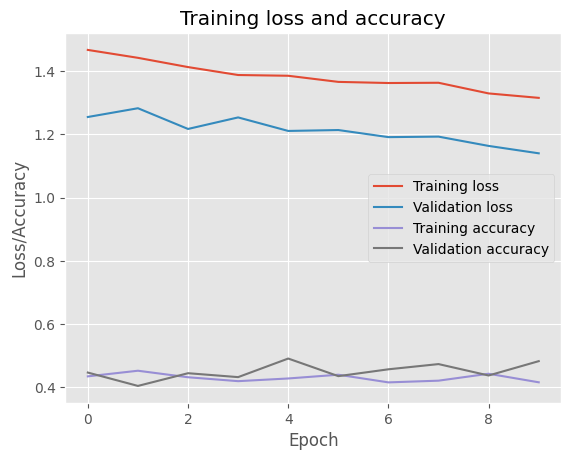

In [36]:
#Learning curve visualization

fig,ax = plt.subplots()
plt.style.use('ggplot')

epochs = len(history.history['loss'])
epoch_values = list(range(epochs))

ax.plot(epoch_values, history.history['loss'], label='Training loss')
ax.plot(epoch_values, history.history['val_loss'], label='Validation loss')
ax.plot(epoch_values, history.history['accuracy'], label='Training accuracy')
ax.plot(epoch_values, history.history['val_accuracy'], label='Validation accuracy')

ax.set_title('Training loss and accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.legend()
plt.show()

In [32]:
# 2 layer: Precission and recall for every variable
print(metrics.classification_report(y_test[1000:],y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       382
           1       0.83      0.74      0.78        46
           2       0.75      0.84      0.79       179
           3       0.68      0.78      0.72       126
           4       0.72      0.69      0.71       168
           5       1.00      0.47      0.64        17
           6       0.82      0.79      0.80        42
           7       0.86      0.51      0.64        49
           8       1.00      0.65      0.78        31
           9       0.90      0.86      0.88        21
          10       1.00      0.44      0.62        18
          11       0.00      0.00      0.00         2

    accuracy                           0.79      1081
   macro avg       0.78      0.64      0.69      1081
weighted avg       0.80      0.79      0.79      1081

